## CSPB 3202 - Artificial Intelligence - Project (OpenAI Gym - MountainCar) 
## Yoshie Bell-Souder

#### Project Overview: 
<b>About Project:</b> We are going to work on our CSPB 3202 AI Project using OpenAI Gym(https://gymnasium.farama.org/). There are much different game environments, such as Cart Pole(https://gymnasium.farama.org/environments/classic_control/cart_pole/), Assault(https://gymnasium.farama.org/environments/atari/assault/). Of the choices, I picked the Mountain Car.

Then I followed the Cart Pole example to test my Mountain Car.

<b>About the environment works and rule:</b>
The car is located at the bottom of the mountain and tries to reach the flag, which is the goal at the top. There are three actions, left, right, and stop. 

<b>About the model:</b>
Using Q-learning, achiving the goal is a higher possibility.  I would like to try to choose the model. Because the action is random and chages every time the script is run, reaching a goal takes time and sometimes is not finished until the maximum of trials.

In [1]:
import gymnasium as gym
# my python file is followed and based on cartpole-2023Spring.ipynb example in this project (Reference)

import warnings
from collections import namedtuple
warnings.filterwarnings("ignore", category=DeprecationWarning)
partition = namedtuple("partition", ["type", "subtype"])

In [2]:
gym.__version__

'0.26.3'

In [3]:
e = gym.make('MountainCar-v0').env

In [4]:
# observation and action space
# Based on https://gymnasium.farama.org/environments/classic_control/mountain_car/
obs = e.observation_space
act = e.action_space # possible actions are 0: left, 1: Don’t accelerate, 2: right
print("The observation space:", format(obs))
print("The action space:", format(act))

The observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The action space: Discrete(3)


In [5]:
# reset
obs_reset = e.reset()
# see the initial observation
print("The initial observation is", format(obs_reset))

# get a sample action
random_act = e.action_space.sample()

# take the action
new_obs = e.step(random_act)
print("random_action: ", random_act)
print("new_obs: ", new_obs)
print("The new observation is", format(new_obs))

The initial observation is (array([-0.45545295,  0.        ], dtype=float32), {})
random_action:  2
new_obs:  (array([-0.4549605 ,  0.00049246], dtype=float32), -1.0, False, False, {})
The new observation is (array([-0.4549605 ,  0.00049246], dtype=float32), -1.0, False, False, {})


In [6]:
from gym.spaces.discrete import Discrete

In [7]:
d = Discrete(3) #the Discrete is a class that has methods .sample and .contains

In [8]:
[d.sample() for x in range(10)] #sample generates an action output

[1, 1, 2, 1, 2, 0, 1, 0, 2, 0]

In [9]:
print(d.contains(0), d.contains(1), d.contains(2), d.contains(3)) 
# with .contains method, we can check whether an integer is a valid action

True True True False


In [10]:
e.step(0)

(array([-0.45597917, -0.0010187 ], dtype=float32), -1.0, False, False, {})

In [11]:
e.step(1) 
# reference: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

(array([-0.45750156, -0.00152237], dtype=float32), -1.0, False, False, {})

In [12]:
e.step(2) 

(array([-0.45851642, -0.00101486], dtype=float32), -1.0, False, False, {})

## Making an agent

In [13]:
# from gym.envs.registration import load_env_plugins as _load_env_plugins
# from gym.envs.registration import make, register, registry, spec

e = gym.make("MountainCar-v0").env

total_reward = 0.0
num_episodes = 20
done = False
for i in range(num_episodes):
    e.reset()
    while done == False:
        e.render()
        state, reward, done, info, moreinfo = e.step(e.action_space.sample())
        num_episodes += 1
        total_reward += reward
        

print("Episode done in %d steps, total reward %.2f" % (num_episodes, total_reward))

/Users/yoshie/opt/anaconda3/lib/python3.9/site-packages/gymnasium/envs/classic_control/mountain_car.py:174: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(


Episode done in 24137 steps, total reward -24117.00


## Monitoring the agent

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import numpy as np

In [15]:
def show_state(e, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(e.render())
    plt.title("%s | Step: %d %s" % (env.spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

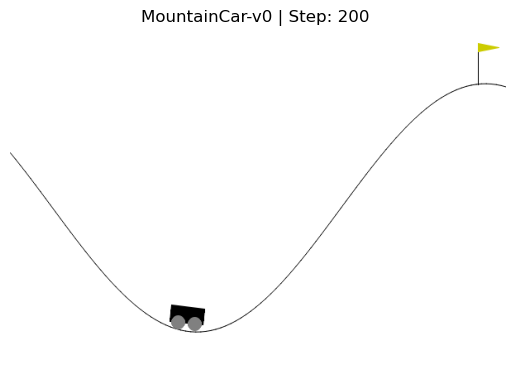

Episode done in 200 steps, total reward -24217.00


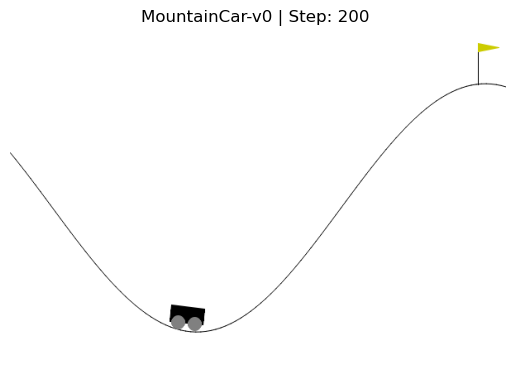

In [16]:
env = gym.make('MountainCar-v0', render_mode='rgb_array').env

# reference https://github.com/bhushan23/OpenAI-Gym-Tutorials/blob/master/GettingStarted/mountain-car.py
# number of episodes - the agent
num_episodes = 100

obs = env.reset()

for step in range(num_episodes):
    # take random action
    action = env.action_space.sample()
    
    # apply the action
    obs, reward, done, info, moreinfo = env.step(action)
    print(reward)
    # Render the env
    env.render()
    
    # Increment the rewards and steps
    total_reward += reward
    num_episodes += 1
    show_state(env,num_episodes)
    # If the epsiode is up, then start another one
    if done:
        env.reset()

# Close the env
print("Episode done in %d steps, total reward %.2f" % (num_episodes, total_reward))
env.close()
env.env.close()

### Problem(rewards): Each timestep gave as -1 to reward. The number of the timesteps used to reach the goal is the negative number reported as the total reward.

## Tune wrappers

### Instead of random action, I am trying to modify the action

The default action looks like it is repeating "State - Action - Reward" randomly.

Then we will use the Q-learning algorithm to update the rule based on the folmula below.

<figure>
  <IMG SRC="https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-d9d0955e19ef869878dd2cf2a2be9373_l3.svg" WIDTH=500>
</figure>
    
I assume to enable our optimal action after adjusting the alpha, gamma and epsilon values.

In [78]:
def Qlearning(env, alpha, gamma, epsilon, min_steps, steps):
    num_states = (env.observation_space.high - env.observation_space.low)*np.array([10,50])
    num_states = np.round(num_states,0).astype(int) + 1
    
    Qlearn = np.random.uniform(low=-1, high=0, size =(num_states[0], num_states[1], 
                                                      env.action_space.n))
    Qinit = np.copy(Qlearn)
    
    reward_list = []
    ave_reward_list = []
    
    first = steps +1
    
    for i in range(steps):
        do=False
        total_reward, reward = 0, 0
        state = env.reset()
#         print(state[0])
#         print(env.observation_space.low)
        state_adj = (state[0] - env.observation_space.low)*np.array([10,50])
        state_adj = np.round(state_adj, 0).astype(int)
        
        while do != True:   
            if np.random.random() < 1:
                action = np.argmax(Qlearn[state_adj[0], state_adj[1]])
            else:
                action = np.random.randint(0,env.action_space.n)
                
            state_next, reward, done, info, more = env.step(action)
            
            state_next_adj = (state_next - env.observation_space.low)*np.array([10,50])
            state_next_adj = np.round(state_next_adj, 0).astype(int)
                        
            if done and state_next[0] >= 0.5:
                Qlearn[state_adj[0], state_adj[1], action] += reward
                
            else:
#                 print('state_next[0]',state_next[0])
                flag0 = state_next[0]
                flag1 = np.max(Qlearn[state_next_adj[0], state_next_adj[1]])
                flag2 = np.max(Qlearn[state_adj[0], state_adj[1]])
                flag = flag0 + flag1 - flag2
                flag = round(flag, 3)
                if (flag >= 0.5):
                    flag = 2
                else:
                    flag =(flag+1.5)/1.7 - 1
#                 print('discount',discount)

                update = alpha*flag
                Qlearn[state_adj[0], state_adj[1],action] += update
                

#             print(reward, state_next[0])
            total_reward += state_next[0]
#             print('total_reward',total_reward)
            state_adj = state_next_adj
            
            
        reward_list.append(total_reward)
#         print('list',np.mean(reward_list))
#         print('i',i)
        env.render()    
        if i % 100 == 0:
                print('Episode', i, 'average reward:', np.mean(reward_list))

        if i % 100 == 0:
                ave_reward = np.mean(reward_list)
                ave_reward_list.append(ave_reward)
                reward_list = []
                
                
#         print('ave_reward',np.mean(reward_list))
#         print('reward_list',reward_list)
    env.close
    return reward_list, Qlearn, Qinit

In [79]:
env.reset()
reward, Q, Q1 = Qlearning(env, 0.2, 0.5, 0.5, 0, 5000)

Episode 0 average reward: -1358.9103503940278
Episode 100 average reward: -436.0823389856037
Episode 200 average reward: -347.60139593029135
Episode 300 average reward: -387.78503528109695
Episode 400 average reward: -339.4331540794992
Episode 500 average reward: -371.600203871101
Episode 600 average reward: -402.60395652867766
Episode 700 average reward: -369.4091923657257
Episode 800 average reward: -316.0891206642932
Episode 900 average reward: -350.3089396333128
Episode 1000 average reward: -328.7254253588887
Episode 1100 average reward: -401.53683268903495
Episode 1200 average reward: -386.2152624831278
Episode 1300 average reward: -342.2834388019594
Episode 1400 average reward: -353.61809995293123
Episode 1500 average reward: -389.68061730618444
Episode 1600 average reward: -418.66061978584025
Episode 1700 average reward: -330.84404007127233
Episode 1800 average reward: -382.3029690507308
Episode 1900 average reward: -311.3425310234019
Episode 2000 average reward: -299.5326132171

In [82]:
print(reward[0])

[-251.99448135111015, -738.0475333554205, -338.04354371200316, -166.35111600637902, -421.129886374576, -443.13862715195864, -248.2917278567329, -290.478836361337, -495.20715737236605, -642.1048171897419, -194.1487199343892, -190.81511749437777, -138.27919710753486, -260.56687710946426, -445.3606267415453, -197.2059623277746, -342.76612850491074, -116.23551215359475, -301.52946526324376, -174.3619228946627, -209.27962669590488, -206.02348064468242, -456.4174294417753, -284.3561319025466, -210.6773870025063, -561.1095449939166, -278.4772888876032, -168.4413133924827, -224.39940558886155, -1348.8902104308363, -470.2832100521773, -129.42497995623853, -368.48706946428865, -539.756399739068, -466.59308157890337, -482.907852944918, -312.51567365197116, -118.57868317840621, -147.51382314460352, -254.89545658475254, -659.8392254470382, -550.1179500329308, -200.54822142515332, -293.9810606332612, -1003.5628821707796, -107.5931458301493, -243.0982170304669, -585.2344364955788, -401.2068578649778,

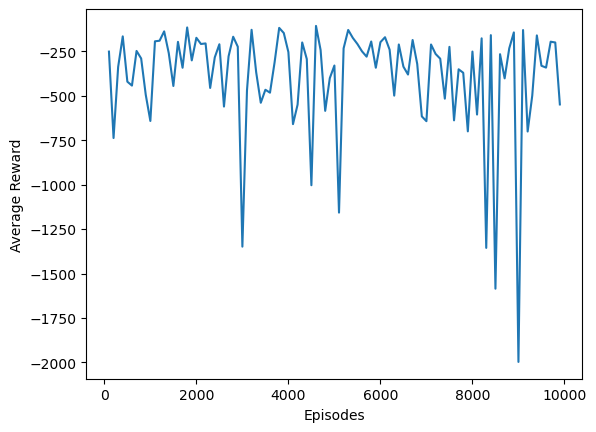

In [84]:
# Plot Rewards 
plt.plot(100*(np.arange(len(reward[0])) + 1), reward[0]) 
plt.xlabel('Episodes') 
plt.ylabel('Average Reward')     
plt.show()

### Conclusion
By the deadline, I was not able to learn and set epsilon and gamma. The code was considered how the next state is close to the flag, adjusting only the alpha value. As you may see in the graph above, the reward is still not able to optimize much, and I could not move the goal flag. However, this is still better compared with the baseline condition of the random actions.

Probably, I need to learn/test more to adjust gamma and epsilon values and include this in the leaning function. If I were able to do it, I can improve the result.

### References used 
- https://www.baeldung.com/cs/epsilon-greedy-q-learning
- https://gymnasium.farama.org/
- https://gymnasium.farama.org/environments/classic_control/mountain_car/
- https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py
- https://github.com/bhushan23/OpenAI-Gym-Tutorials/blob/master/GettingStarted/mountain-car.py
- https://vadim.me/publications/heartpole/
- https://towardsdatascience.com/q-learning-algorithm-from-explanation-to-implementation-cdbeda2ea187
- https://www.baeldung.com/cs/epsilon-greedy-q-learning
- https://condor.depaul.edu/ntomuro/courses/594-ADL/assign/Getting%20Started%20with%20Reinforcement%20Learning%20and%20Open%20AI%20Gym.pdf